## Курсовая работа Credit Default

### Подключение библиотек и скриптов

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV

import xgboost as xgb, lightgbm as lgbm, catboost as catb

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
* **Current Credit Balance** - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [3]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


### EDA


**Анализ целевой переменной**


In [4]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Дисбаланс классов налицо, надо будет с ним бороться

#### Признаки

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### Количественные переменные

In [6]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### Номинативные переменные

In [7]:
# non_num_vars.remove('Price')
non_num_vars = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
for col in non_num_vars:
    print(col, train_df[col].value_counts(), '\n', sep='\n')

Home Ownership
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64


Years in current job
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64


Purpose
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64


Term
Short Term    5556
Long Term     1944
Name: Term, dtype: int64




### Обработка выбросов и пропусков

**Annual Income**

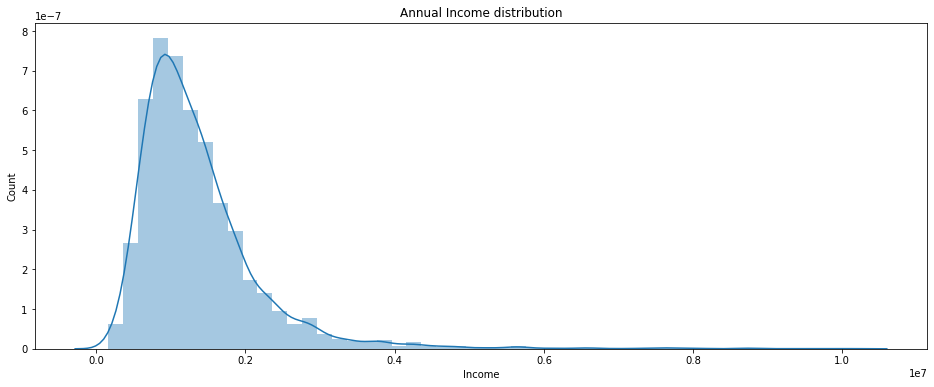

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

In [8]:
plt.figure(figsize = (16, 6))

sns.distplot(train_df['Annual Income'])
plt.ylabel('Count')
plt.xlabel('Income')

plt.title('Annual Income distribution')
plt.show()
train_df['Annual Income'].describe()

Пропуски можно заполнить медианой

In [9]:
train_df.loc[train_df['Annual Income'].isna(), 'Annual Income'] = train_df['Annual Income'].median()
train_df['Annual Income'].describe()

count    7.500000e+03
mean     1.325286e+06
std      7.567551e+05
min      1.645970e+05
25%      9.311330e+05
50%      1.168386e+06
75%      1.499974e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

**Maximum Open Credit**

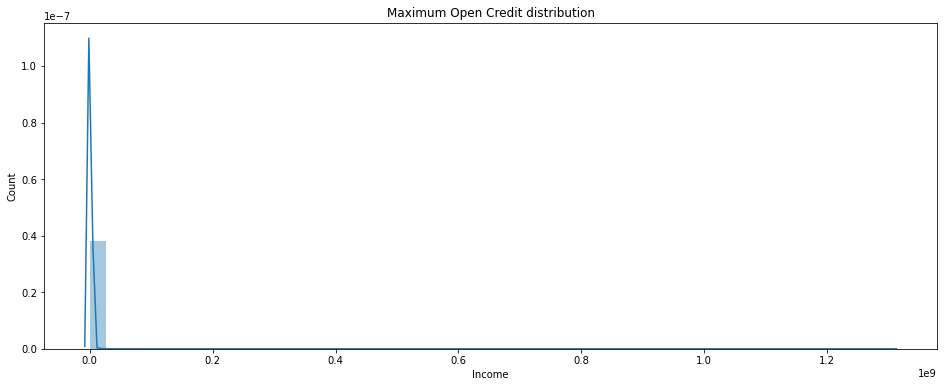

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

In [10]:
plt.figure(figsize = (16, 6))

sns.distplot(train_df['Maximum Open Credit'])
plt.ylabel('Count')
plt.xlabel('Income')

plt.title('Maximum Open Credit distribution')
plt.show()

train_df['Maximum Open Credit'].describe()

Maximum Open Credit, который превышает максимально доступный кредит 99 999 999 можно установить в максимальное значение текущего кредита - 99 999 999

In [11]:
moc_condition = train_df['Maximum Open Credit'] > 99999999
train_df.loc[moc_condition, 'Maximum Open Credit'] = 99999999
train_df['Maximum Open Credit'].describe()

count    7.500000e+03
mean     7.251149e+05
std      2.353864e+06
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.000000e+08
Name: Maximum Open Credit, dtype: float64

**Months since last delinquent**

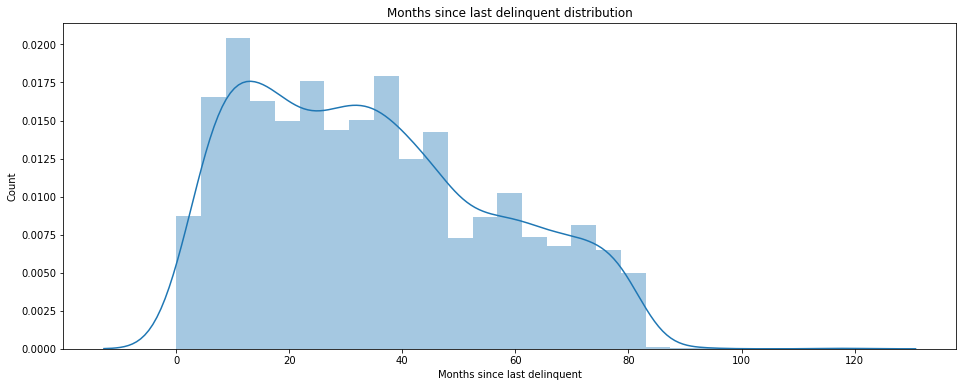

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

In [12]:
plt.figure(figsize = (16, 6))

sns.distplot(train_df['Months since last delinquent'])
plt.ylabel('Count')
plt.xlabel('Months since last delinquent')

plt.title('Months since last delinquent distribution')
plt.show()
train_df['Months since last delinquent'].describe()

Для этого признака много пропусков, но, скорее всего, эти пропуски говорят об отсутствии просрочек и их просто можно заполнить 0.

In [13]:
train_df.loc[train_df['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0
train_df['Months since last delinquent'].describe()

count    7500.000000
mean       15.815200
std        22.649441
min         0.000000
25%         0.000000
50%         0.000000
75%        29.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

**Bankruptcies**

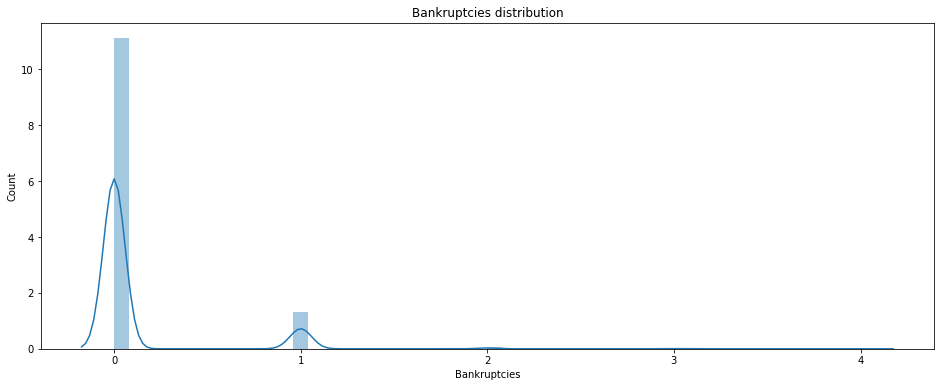

count    7486.000000
mean        0.117152
std         0.347192
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Bankruptcies, dtype: float64

In [14]:
plt.figure(figsize = (16, 6))

sns.distplot(train_df['Bankruptcies'])
plt.ylabel('Count')
plt.xlabel('Bankruptcies')

plt.title('Bankruptcies distribution')
plt.show()
train_df['Bankruptcies'].describe()

Для этого признака также пропуски скорее говорят об отсутствии банкротств в прошлом и их просто можно заполнить 0.

In [15]:
train_df.loc[train_df['Bankruptcies'].isna(), 'Bankruptcies'] = 0
train_df['Bankruptcies'].describe()

count    7500.000000
mean        0.116933
std         0.346904
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Bankruptcies, dtype: float64

**Current Loan Amount**

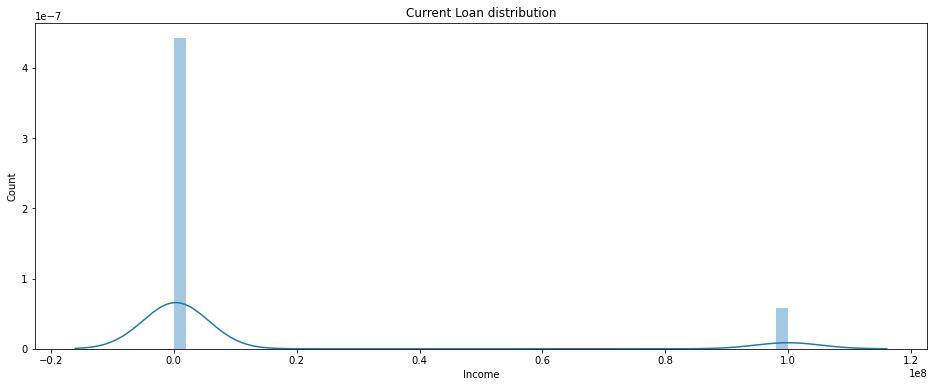

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

In [16]:
plt.figure(figsize = (16, 6))

sns.distplot(train_df['Current Loan Amount'])
plt.ylabel('Count')
plt.xlabel('Income')

plt.title('Current Loan distribution')
plt.show()
train_df['Current Loan Amount'].describe()

Заменяем 99999999 на медиану, групируя по Term и Purpose.

In [17]:
condition = train_df['Current Loan Amount'] >= 99999999
train_df.loc[condition, 'Current Loan Amount'] = train_df.loc[~condition, 'Current Loan Amount'].median()

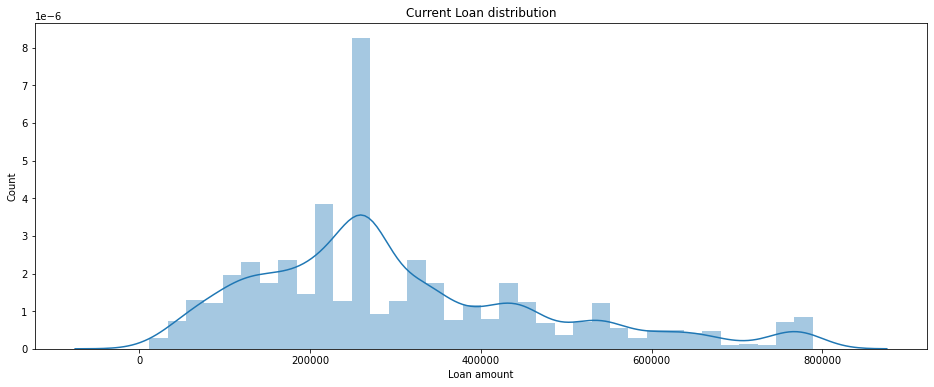

count      7500.000000
mean     304013.377067
std      171951.057747
min       11242.000000
25%      180169.000000
50%      265826.000000
75%      396929.500000
max      789030.000000
Name: Current Loan Amount, dtype: float64

In [18]:
plt.figure(figsize = (16, 6))

sns.distplot(train_df['Current Loan Amount'])
plt.ylabel('Count')
plt.xlabel('Loan amount')

plt.title('Current Loan distribution')
plt.show()
train_df['Current Loan Amount'].describe()

**Credit Score**

In [19]:
train_df['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

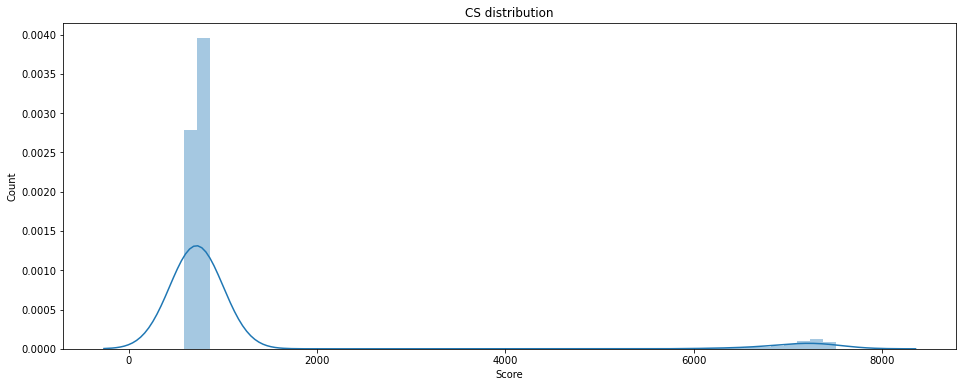

In [20]:
plt.figure(figsize = (16, 6))

sns.distplot(train_df['Credit Score'])
plt.ylabel('Count')
plt.xlabel('Score')

plt.title('CS distribution')
plt.show() 

В США общий кредитный рейтинг изменяется в пределах от 300 до 850, следовательно значения за пределами этого интервала являются ошибками, которые нужно исправить. значения в диапазоне 3000 - 8500 это скорее всего ошибка ввода, приведшая к искажению результата в 10 раз.

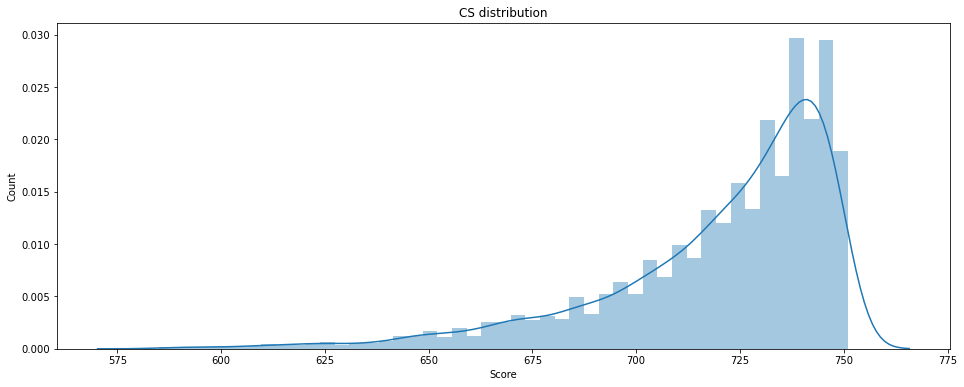

In [21]:
train_df.loc[(train_df['Credit Score'] >= 3000) & (train_df['Credit Score'] <= 8500), 'Credit Score'] = \
    train_df.loc[train_df['Credit Score'] > 1000, 'Credit Score'] / 10

plt.figure(figsize = (16, 6))

sns.distplot(train_df['Credit Score'])
plt.ylabel('Count')
plt.xlabel('Score')

plt.title('CS distribution')
plt.show()

Пропуски по этому признаку заменяем на медиану

In [22]:
train_df.loc[train_df['Credit Score'].isna(), 'Credit Score'] = train_df['Credit Score'].median()
train_df['Credit Score'].describe()

count    7500.000000
mean      721.937333
std        25.147440
min       585.000000
25%       715.000000
50%       729.000000
75%       738.000000
max       751.000000
Name: Credit Score, dtype: float64

## Обработка номинативных признаков

**Home Ownership**

In [23]:
train_df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Вероятно Home Mortgage и Have Mortgage значают одно и то же.

In [24]:
train_df.loc[train_df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

In [25]:
train_df['Home Ownership'].value_counts()

Home Mortgage    3649
Rent             3204
Own Home          647
Name: Home Ownership, dtype: int64

**Years in current job**

Пропуски заполним модой

In [26]:
train_df.loc[train_df['Years in current job'].isna(), 'Years in current job'] = train_df['Years in current job'].mode()[0]

In [27]:
train_df.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

### Класс для подготовки данных

In [28]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.ycj_mode = None
        self.min_credit_score = None
        self.max_credit_score = None
        self.CurrentLoanAggMed = None
       

    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.ycj_mode = X['Years in current job'].mode()[0]
        self.max_credit = 99999999
        self.min_credit_score = 3000
        self.max_credit_score = 8500
        
        current_loan_outliers = X[X['Current Loan Amount'] == self.max_credit][['Current Loan Amount', 'Purpose', 'Term']]
        self.CurrentLoanAggMed = current_loan_outliers.groupby(['Purpose', 'Term']) \
                                     .agg({'Current Loan Amount':'median'}) \
                                     .rename(columns={'Current Loan Amount':'Current_Loan_Amount_Agg_Med'})
        
        
    def transform(self, X):
        """Трансформация данных"""

        # Annual Income
        X['AnnualIncome_Nan'] = 0
        X.loc[train_df['Annual Income'].isna(), 'AnnualIncome_Nan'] = 1
        
        # Maximum Open Credit
        condition = X['Maximum Open Credit'] >= self.max_credit
        X.loc[condition, 'Maximum Open Credit'] = self.max_credit
        
        # Months since last delinquent
        X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0
        
        # Bankruptcies
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies'] = 0
#         X.loc[X['Bankruptcies'] > 1, 'Bankruptcies'] = 1
        
        # Current Loan Amount
#         condition = X['Current Loan Amount'] == self.max_credit
#         X.loc[condition, 'Current Loan Amount'] = X.loc[~condition, 'Current Loan Amount'].median()
        
        X = X.merge(self.CurrentLoanAggMed, on=['Purpose', 'Term'], how='left')
        X.loc[X['Current Loan Amount'] >= self.max_credit, 'Current Loan Amount'] = X['Current_Loan_Amount_Agg_Med']
        
        # Credit Score
        X.loc[(X['Credit Score'] >= self.min_credit_score) & (X['Credit Score'] <= self.max_credit_score), 
              'Credit Score'] = X.loc[X['Credit Score'] > 1000, 'Credit Score'] / 10
        X['CreditScore_Nan'] = 0
        X.loc[train_df['Annual Income'].isna(), 'CreditScore_Nan'] = 1

        # Home Ownership
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
        
        # Years in current job
        X.loc[X['Years in current job'].isna(), 'Years in current job'] = self.ycj_mode
        
        X.fillna(self.medians, inplace=True)
        
        return X

### Новые признаки

#### Home ownership

Преобразуем в бинарные признаки

In [29]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Home Ownership'])], axis=1)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Home Mortgage,Own Home,Rent
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,265826.0,47386.0,7914.0,749.0,0,0,1,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,0,1,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,265826.0,308389.0,13651.0,742.0,0,1,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0,1,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0,0,1


#### Years in current job

Преобразуем в числовые категории

In [30]:
train_df['Years in current job'] = train_df['Years in current job'].map({'< 1 year':0, 
                                                                       '1 year':1, 
                                                                       '2 years':1, 
                                                                       '3 years':1, 
                                                                       '4 years':2, 
                                                                       '5 years':2, 
                                                                       '6 years':3, 
                                                                       '7 years':3,
                                                                       '8 years':3,
                                                                       '9 years':3,
                                                                       '10+ years':4})
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Home Mortgage,Own Home,Rent
0,Own Home,482087.0,4,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,265826.0,47386.0,7914.0,749.0,0,0,1,0
1,Own Home,1025487.0,4,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,0,1,0
2,Home Mortgage,751412.0,3,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,265826.0,308389.0,13651.0,742.0,0,1,0,0
3,Own Home,805068.0,3,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0,1,0
4,Rent,776264.0,3,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0,0,1


#### Purpose                       

Преобразуем в бинарные признаки 

In [31]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Purpose'])], axis=1)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,home improvements,major purchase,medical bills,moving,other,renewable energy,small business,take a trip,vacation,wedding
0,Own Home,482087.0,4,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,Own Home,1025487.0,4,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,751412.0,3,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,Own Home,805068.0,3,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,Rent,776264.0,3,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


#### Term

Преобразуем в бинарный признак Long Term

In [32]:
train_df['Long Term'] = train_df['Term'].map({'Long Term': 1, 'Short Term': 0})
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,major purchase,medical bills,moving,other,renewable energy,small business,take a trip,vacation,wedding,Long Term
0,Own Home,482087.0,4,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,Own Home,1025487.0,4,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,Home Mortgage,751412.0,3,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,Own Home,805068.0,3,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,Rent,776264.0,3,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
train_df['credit burden'] = train_df['Monthly Debt'] * 12 / train_df['Annual Income']
train_df['credit burden'].describe()

count    7500.000000
mean        0.175129
std         0.090706
min         0.000000
25%         0.110996
50%         0.167001
75%         0.229942
max         0.987793
Name: credit burden, dtype: float64

## Код для создания новых признаков, балансировки классов и оценки результатов модели

In [34]:
def get_metrics(report):
    f1_macro = report['macro avg']['f1-score']
    f1_0 = report['0']['f1-score']
    f1_1 = report['1']['f1-score']
    return f1_macro, f1_0, f1_1

In [35]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [36]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [37]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [38]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.terms_map = None
        self.ycj_map = None
        self.dummy_columns = {}
        
        
    def fit(self, X, y=None):
        self.terms_map = {'Long Term': 1, 'Short Term': 0}
        self.ycj_map = {'< 1 year':0, 
                       '1 year':1, 
                       '2 years':1, 
                       '3 years':1, 
                       '4 years':2, 
                       '5 years':2, 
                       '6 years':3, 
                       '7 years':3,
                       '8 years':3,
                       '9 years':3,
                       '10+ years':4}
        
        self.dummy_columns['Home Ownership'] = pd.get_dummies(X['Home Ownership']).columns.to_list()
        self.dummy_columns['Purpose'] = pd.get_dummies(X['Purpose']).columns.to_list()
                

    def transform(self, X):
        
        X = X.copy()
        
        # Binary features
        X['Long Term'] = X['Term'].map(self.terms_map)
        
        # Dummies
        X = self.get_dummies(X, 'Home Ownership')
        X = self.get_dummies(X, 'Purpose')

        # categorial to numbers
        X['Years_in_current_ job_cat'] = X['Years in current job'].map(self.ycj_map)
        
        # credit burden
        X['credit burden'] = X['Monthly Debt'] * 12 / X['Annual Income']

        
        return X
    
    def get_dummies(self, X, src_col):
        new_dummies = pd.get_dummies(X[src_col])
        X = pd.concat([X, new_dummies], axis=1)

        # in case train data had more values than test
        new_cols = new_dummies.columns.to_list()
        missing_cols = [col for col in self.dummy_columns[src_col] if col not in new_dummies]
        for col in missing_cols:
            X[col] = 0
            
        return X


In [39]:
feature_names = ['Annual Income', 
#                  'Years in current job',
                 'Tax Liens', 
                 'Number of Open Accounts', 
                 'Years of Credit History',
                 'Maximum Open Credit', 
                 'Number of Credit Problems', 
                 'Months since last delinquent', 
                 'Bankruptcies',
#                  'Purpose', 
#                  'Term',
#                  'Home Ownership',
                 'Years_in_current_ job_cat',
                 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

new_feature_names = [
                     'Long Term'
#                      , 'Home Mortgage'
#                      , 'Own Home'
#                      , 'AnnualIncome_Nan'
                     , 'CreditScore_Nan'
#                      , 'Rent'
                     , 'business loan'
#                      , 'Current_Loan_Amount_Agg_Med'
#                      , 'major purchase'
#                      , 'buy a car'
#                      , 'buy house' 
#                      , 'debt consolidation' 
#                      , 'educational expenses', 'home improvements', 
#                      'medical bills', 'moving', 'other', 'renewable energy', 'small business', 'take a trip', 'vacation',
#                      'wedding'
                      , 'credit burden'
                    ]
# cat_feature_names = ['Purpose', 
# #                      'Term',
#                      'Home Ownership'
# #                      , 'Years in current job'
#                     ]

target_name = 'Credit Default'

In [40]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42
                                                      , stratify=y
                                                     )

### Подготовка данных

In [41]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

orig_test_df = test_df.copy()

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((5250, 19), (2250, 19), (2500, 19))

### Добавление новых признаков

In [42]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape
# X_train.columns.to_list()

((5250, 40), (2250, 40), (2500, 40))

In [43]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### Балансировка классов

In [44]:
def init_models(disbalance):
    model_xgb = xgb.XGBClassifier(random_state=21)
    model_lgbm = lgbm.LGBMClassifier(random_state=21)
    model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

    frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':42,
    #      'cat_features':cat_feature_names,
     'eval_metric':'F1',
     'early_stopping_rounds':20
    }
    
    model_catb = catb.CatBoostClassifier(**frozen_params, 
                                         iterations=200, 
                                         max_depth=5,
                                         min_data_in_leaf=3)
    
    model_lgbm = lgbm.LGBMClassifier(random_state=21, 
                                 max_depth=5,
                                 num_leaves=3,
                                 n_estimators=200
                                )

    model_xgb = xgb.XGBClassifier(random_state=21, 
                                  max_depth=3,
                                  max_leaves=5,
                                  n_estimators=100,
                                  max_delta_step=1,
                                  verbosity=0
                                 )
    
    models = [
        ('xgb', model_xgb),
        ('lgbm', model_lgbm),
        ('cat', model_catb)
    ]
    return models

In [45]:
def run_experiment(X_train, X_test, y_train, y_test, method='tomek'):
    assert method in ['not', 'over', 'under', 'tomek', 'smote'], 'Неправильный метод сэмплирования'
    
    disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
    models = init_models(disbalance)
    
    stata = pd.DataFrame()
    for name, model in models:
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        report_train = classification_report(y_train, pred_train, output_dict=True)
        report_test = classification_report(y_test, pred_test, output_dict=True)
        f1_macro_train, f1_0_train, f1_1_train = get_metrics(report_train)
        f1_macro_test, f1_0_test, f1_1_test = get_metrics(report_test)

        stata = stata.append({
            'model_name': name,
            f'f1_macro_train_{method}': f1_macro_train,
            f'f1_macro_test_{method}': f1_macro_test,
            f'f1_class_0_train_{method}': f1_0_train,
            f'f1_class_0_test_{method}': f1_0_test,
            f'f1_class_1_train_{method}': f1_1_train,
            f'f1_class_1_test_{method}': f1_1_test
        }, ignore_index=True)
    return stata, models

In [46]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()
X = X_train.copy()
y = y_train.copy()
balanced_X_train, balanced_y_train = tl.fit_resample(X, y)

In [47]:
model_stats, estimators = run_experiment(X_train, X_valid, y_train, y_valid, method='not')
model_stats

,f1_class_0_test_not,f1_class_0_train_not,f1_class_1_test_not,f1_class_1_train_not,f1_macro_test_not,f1_macro_train_not,model_name
0,0.828221,0.876977,0.326039,0.540370,0.577130,0.708673,xgb
1,0.832744,0.847513,0.252734,0.308017,0.542739,0.577765,lgbm
2,0.717878,0.822743,0.487163,0.682784,0.602521,0.752764,cat


In [48]:
model_stats, estimators = run_experiment(balanced_X_train, X_valid, balanced_y_train, y_valid)
model_stats

,f1_class_0_test_tomek,f1_class_0_train_tomek,f1_class_1_test_tomek,f1_class_1_train_tomek,f1_macro_test_tomek,f1_macro_train_tomek,model_name
0,0.810637,0.870170,0.398887,0.620747,0.604762,0.745459,xgb
1,0.820658,0.831069,0.352459,0.430883,0.586559,0.630976,lgbm
2,0.708304,0.825625,0.511296,0.718162,0.609800,0.771893,cat


### CatBoost

In [49]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5496957403651117

In [50]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':42,
#      'cat_features':cat_feature_names,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}




### Подбор модели

In [51]:
# %%time

# from sklearn.model_selection import StratifiedKFold

# model_catb = catb.CatBoostClassifier(**frozen_params)
# params = {'iterations':[30, 40, 50, 75, 100, 150, 200, 250, 300],
#           'max_depth':[3, 4, 5, 6, 7, 10],
#           'min_data_in_leaf':[3, 4, 5, 10]}
# # cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
# best_params = model_catb.grid_search(params, balanced_X_train, balanced_y_train, cv=3, stratified=True, refit=True, verbose=False)
# print(best_params)

In [52]:
%%time

# iterations=150, max_depth=5,  min_data_in_leaf=3

model_catb = catb.CatBoostClassifier(**frozen_params, 
                                     iterations=200, 
                                     max_depth=5,
                                     min_data_in_leaf=3)
model_catb.fit(X_train, y_train, eval_set=(X_valid, y_valid))

# evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)
evaluate_preds(model_catb, balanced_X_train, X_valid, balanced_y_train, y_valid)


TRAIN

              precision    recall  f1-score   support

           0       0.85      0.51      0.63      3246
           1       0.43      0.80      0.56      1479

    accuracy                           0.60      4725
   macro avg       0.64      0.65      0.59      4725
weighted avg       0.72      0.60      0.61      4725

TEST

              precision    recall  f1-score   support

           0       0.87      0.50      0.64      1616
           1       0.39      0.80      0.52       634

    accuracy                           0.59      2250
   macro avg       0.63      0.65      0.58      2250
weighted avg       0.73      0.59      0.60      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               810  806
1               125  509
Wall time: 101 ms


**Важность признаков**

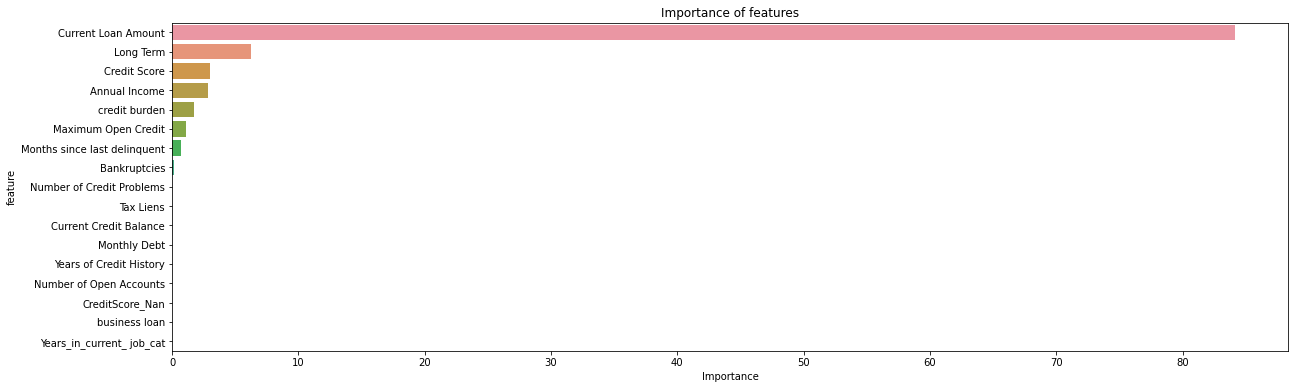

In [53]:
show_feature_importances(X_train.columns, model_catb.feature_importances_)

In [54]:
catb_y_test_preds = model_catb.predict(test_df)

In [55]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [56]:
submit[target_name] = catb_y_test_preds
submit.head()

,Id,Credit Default
0,0,0
1,1,1
2,2,1
3,3,0
4,4,1


In [57]:
submit.to_csv('catb_submit.csv', index=False)